<a href="https://colab.research.google.com/github/WeinanZhi/-CS539-PlantSeedPrediction/blob/master/Res18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import torch
import tensorflow as tf
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path ="/content/drive/My Drive/课程作业/MachineLearning/MLproject/ProcessedData"
sampleX = torch.load(path+'/sample_train_X.pt')
# raw_sampleX = torch.load(path+'/sample_train_X.pt').numpy()
# sampleX = np.squeeze(raw_sampleX)
sampleY = np.loadtxt(path+'/sample_train_Y.txt').astype(np.int64)
sampleY = torch.from_numpy(sampleY)

print(sampleX.size())
print(sampleY.size())

torch.Size([2371, 3, 224, 224])
torch.Size([2371])


In [0]:

dataset = torch.utils.data.TensorDataset(sampleX, sampleY)

data_size = int(0.25 * len(dataset))  #只取1/4的数据作为dataset
dataset, _ = torch.utils.data.random_split(dataset, [data_size, len(dataset)-data_size])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataset_sizes={
    "Train":train_size,
    "Test":test_size
}

class_names = ["Black grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

# 把 dataset 放入 DataLoader
Train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

Test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

dataloaders={
    "Train":Train_loader,
    "Test":Test_loader
}

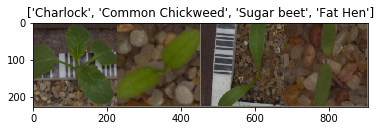

In [0]:


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(Train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# training model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#可视化一些prediction
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  #设置为evaluation模式
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:

#Fine tuning


model_ft = models.resnet18(pretrained=True)   #使用resnet18
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 12)  #保留fc最后一层的in_feature=512,输出为12

# model_ft.load_state_dict(torch.load('params.pkl'))  #加载训练好的模型

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs, learning rate 每7个epoch缩小为0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
torch.save(model_ft.state_dict(), 'params.pkl')


Epoch 0/24
----------
Train Loss: 2.0904 Acc: 0.2981
Test Loss: 1.5789 Acc: 0.5546

Epoch 1/24
----------
Train Loss: 1.1641 Acc: 0.6300
Test Loss: 1.1453 Acc: 0.6471

Epoch 2/24
----------
Train Loss: 0.6740 Acc: 0.7992
Test Loss: 0.6210 Acc: 0.7815

Epoch 3/24
----------
Train Loss: 0.4340 Acc: 0.8605
Test Loss: 0.6981 Acc: 0.7395

Epoch 4/24
----------
Train Loss: 0.3793 Acc: 0.8816
Test Loss: 0.4750 Acc: 0.8403

Epoch 5/24
----------
Train Loss: 0.2331 Acc: 0.9387
Test Loss: 0.5296 Acc: 0.7731

Epoch 6/24
----------
Train Loss: 0.2455 Acc: 0.9281
Test Loss: 0.7238 Acc: 0.7899

Epoch 7/24
----------
Train Loss: 0.1694 Acc: 0.9535
Test Loss: 0.6016 Acc: 0.8151

Epoch 8/24
----------
Train Loss: 0.1732 Acc: 0.9598
Test Loss: 0.5465 Acc: 0.8235

Epoch 9/24
----------
Train Loss: 0.1393 Acc: 0.9577
Test Loss: 0.5921 Acc: 0.7815

Epoch 10/24
----------
Train Loss: 0.1120 Acc: 0.9725
Test Loss: 0.5255 Acc: 0.8319

Epoch 11/24
----------
Train Loss: 0.0725 Acc: 0.9873
Test Loss: 0.4769 Acc